# Implementación del PSO lbest
Se comienza por importar las librerias con algunas utilidades como manejo de arreglos, numeros aleatorios y funciones de prueba

In [7]:
# Manejo de arreglos y operaciones matematicas
import numpy as np

# Importar funciones
import import_ipynb
from utils import FuncionesObjetivo as f

# Numeros aleatorios
import random

# Para visualizar las animaciones
%matplotlib notebook

## Implementacion de funciones
Ahora se implementan funciones que se usaran en la implementacion del algoritmo

In [8]:
def crear_vecindarios(X, k):
    """
    Esta funcion crea los vecindarios de k vecinos para las n particulas
    - input:
        - X: poblacion
        - k: numero de vecinos de cada particula
    """
    # Se puede optimizar?
    # Checar si el numero de vecinos es valido
    if (k % 2 != 0) or k > len(X):
        print("Ingrese un número de vecinos valido (par y menor o igual al numero de particulas)")
        return
    else:
        vecindarios = []
        # Crear vecindarios
        for i in range(len(X)):
            vecindarios.append(np.arange(i-k/2, i+k/2+1))  # Los vecinos son los k/2 anteriores y los k/siguientes
        vecinos = np.array(vecindarios).astype(int)
        # Poner todos los indices dentro del rango valido para los indices
        vecinos[vecinos > len(X) -1] -= len(X)
        return vecinos
    
def obtener_mejorn(X, neigh, funcion):
    """
    Esta funcione obtiene el mejor de cada vecindario
    input: 
        - X: poblacion
        - neigh: vecindarios de cada particula
        - funcion: funcion objetivo
    output: lista con los mejores de cada vecindario
    """
    # Lista para colocar los mejores de cada vecindario
    y_hats = np.zeros_like(X)
    for i in range(len(neigh)):
        N = X[neigh[i]]  # Miembros del vecindario
        y_hat = N[np.argmin(funcion(N))]  # Obtener el mejor del vecindario i
        y_hats[i] = y_hat.reshape(-1, X.shape[1])  # Actualizar el mejor del vecindario
    return y_hats

def pl_best(X, y, y_hat, X_ft, y_ft, neigh, funcion):
    """
    Esta funcion actualiza el personal best de cada particula y el mejor de cada vecindario
    - input: 
        - X: poblacion
        - y: personal best actual de cada particula
        - y_hat: global best
        - X_ft: fitness de la poblacion
        - y_ft: fitness del personal best
        - neigh: vecindarios
        - funcion: funcion objetivo
    - output: personal best y global best actualizados
    """
    # Obtener el indice de las particulas donde su nueva posicion es mejor que su personal best
    idx_mejoresp = np.where(X_ft < y_ft)
    
    # Actualizar personal best
    y[idx_mejoresp] = X[idx_mejoresp]
    
    # Obtener el fitness de los vecindarios actualizados
    y_hat_temp = obtener_mejorn(X, neigh, funcion)
    
    # Obtener el indice de las particulas del vecindario donde su nueva posicion es mejor que su mejor del neigh
    idx_mejoresn = np.where(funcion(y_hat_temp) < funcion(y_hat))
    
    # Actualizar los mejores de los vecindarios
    y_hat[idx_mejoresn] = y_hat_temp[idx_mejoresn]
    
    return y, y_hat

def actualizar_vel(v, X, y, y_hat, c1, c2):
    """
    Esta funcion actualiza la velocidad de las particulas
    - input:
        - v: velocidad actual de las particulas
        - X: posicion actual de las particulas
        - y: personal best de cada particula
        - y_hat: global best
        - c1, c2: constantes para peso de la componente personal y social
    - output: velocidad actualizada de cada particula
    """
    # Calcular nueva velocidad
    v = w * v + (c1 * np.random.uniform(0, 1, (len(X), 1)) * (y - X)) + (c2 * np.random.uniform(0, 1, (len(X), 1)) * (y_hat - X))
    
    return v

## Definir Hiperparametros del algoritmo

In [9]:
# ------------------ Del Problema ------------------
d = 2  # Numero de dimensiones
funcion = f.f_schwefel # funcion objetivo
rango = [[-500, 500]]  # Rango de las variables
mark = [420.96, 420.96, 0]  # Minimo real (si se conoce)

# ------------------ Del Algoritmo ------------------
n = 50  # Numero de particulas
k = 2  # Numero de vecinos (debe ser par y menor o igual a n)
w = 0.9  # Factor de inercia
c1 = 0.5  # Peso cognitivo
c2 = 0.3  # Peso social
max_gen = 100  # Maximo de generaciones
tol = 1e-6  # Tolerancia para detener el algoritmo

# ------------------ Del visualizacion ------------------
animacion = True  # Realizar animacion o no
levels = 20 # numero de curvas de nivel

El óptimo está en [420.968 420.988] con un fitness de 0.0001
Obtenido en la generación 100


<IPython.core.display.Javascript object>


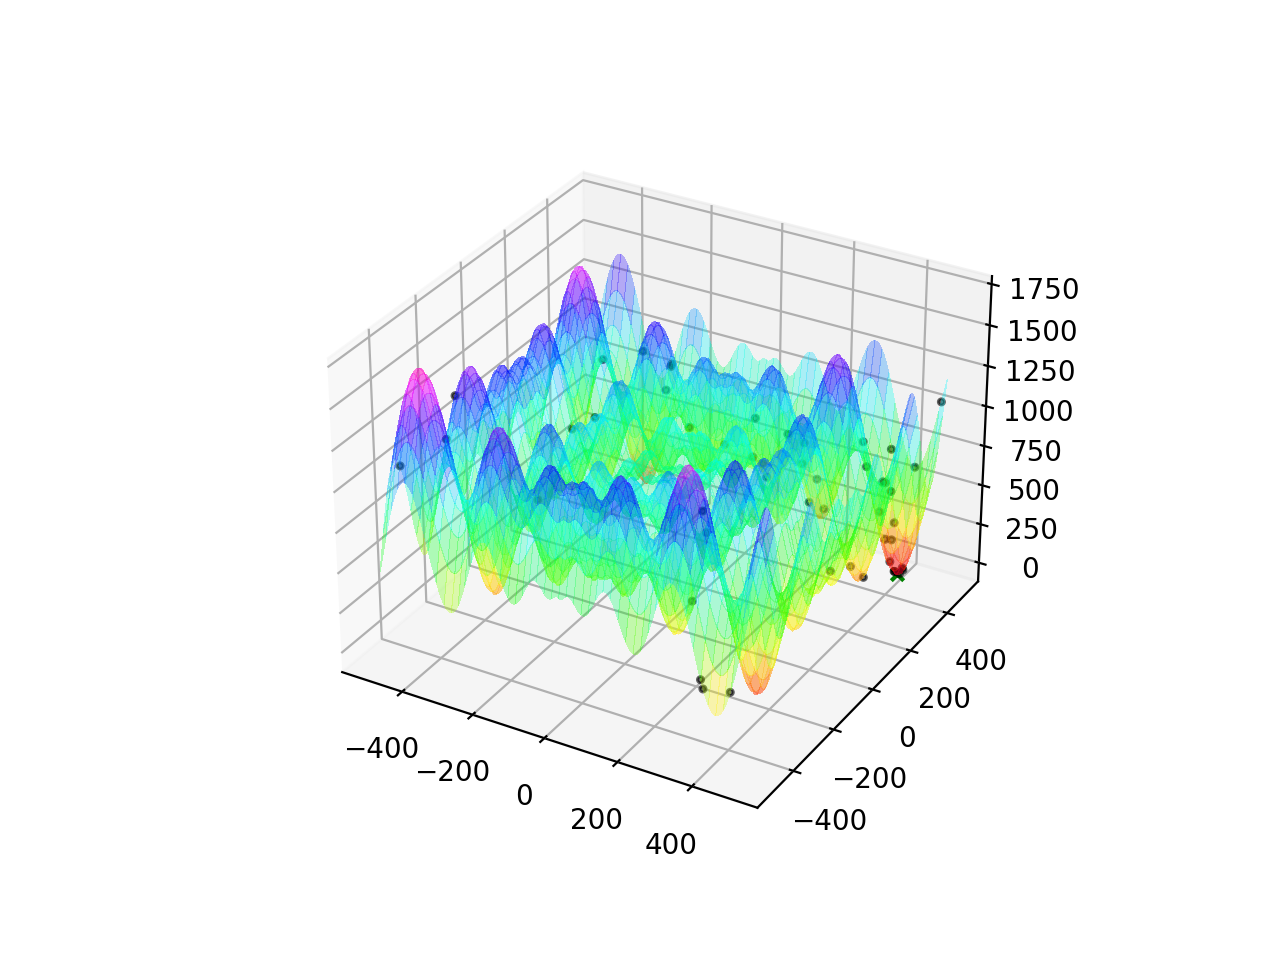

<IPython.core.display.Javascript object>


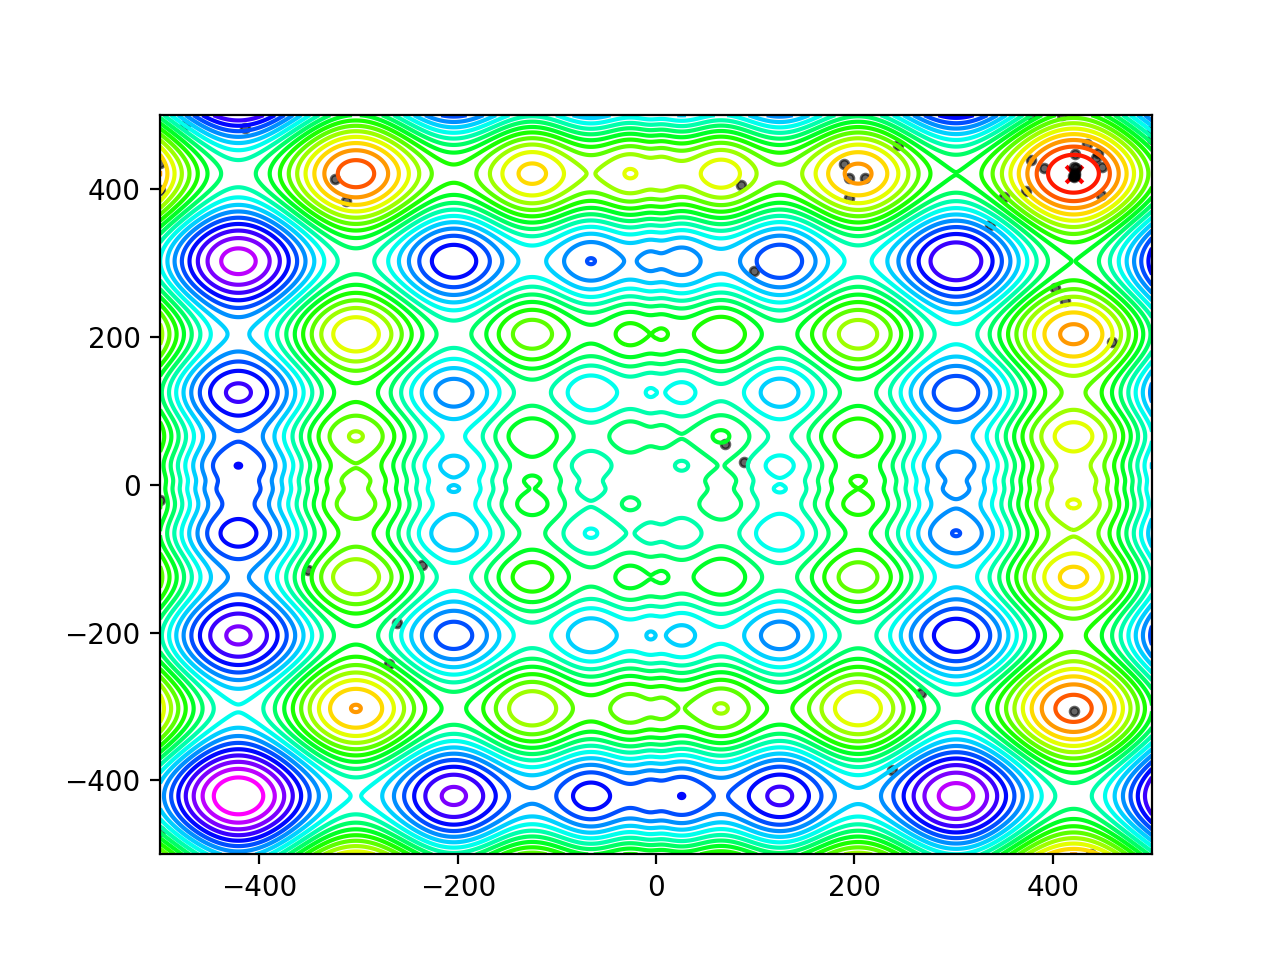

In [10]:
# Si solo hay un rango se considera el mismo rango para todas las variables
if len(rango) == 1:
    rango *= d
# Convertir rango a np.array
rango = np.array(rango)

# Definimos un mejor fitness grande para iniciar el algoritmo
mejor_fitness= np.infty
gen = 0

# Crear un vetor de soluciones para cada dimension con su rango dado
X = np.random.uniform(low=rango[:, 0], high=rango[:,1], size=((n, d)))

# El personal best se inicializa con la poblacion ya que no ha habido actualizacion
y = X.copy() 

# Crear vecindarios
neigh = crear_vecindarios(X, k)

# Inicializar el global best con el minimo de cada vecindario
y_hat = obtener_mejorn(X, neigh, funcion)

# Incializar aleatoriamente la velocidad de las particulas
v = np.random.uniform(low=rango[:, 0], high=rango[:,1], size=((n, d)))

# Variable para guardar la historia de cada generacion (para animar)
historia = []

# Seguir con el algoritmo mientra sean menos de 200 generaciones o el fitness sea menor a 0.001
while((mejor_fitness > tol) and (gen < max_gen)):
    # Calcular el fitness del personal best
    y_ft = funcion(y)
    
    # Fitness del mejor global
    y_hat_ft = funcion(y_hat)
    
    # Fitness de la poblacion
    X_ft = funcion(X)
    
    # Guardar la posicion de la generacion actual si se va a animar
    if animacion:
        img = np.hstack((X, X_ft.reshape(-1, 1)))
        historia.append(img)
    
    # Actualizar el personal y global best
    y, y_hat = pl_best(X, y, y_hat, X_ft, y_ft, neigh, funcion)
    
    # Actualizar el mejor fitness actual
    mejor_fitness_idx = np.argmin(funcion(y_hat))  # idx del mejor fitness
    mejor_fitness = funcion(y_hat)[mejor_fitness_idx]  # valor del mejor fitness
    mejor_part = y_hat[mejor_fitness_idx]  # Mejor particula
    
    # Actualizar velocidad
    v = actualizar_vel(v, X, y, y_hat, c1, c2)
    
    # Actualizar la posicion de las particulas
    X += v
    
    # Clipear para evitar que los valores se salgan del rango
    X = np.clip(X, a_min=rango[:, 0], a_max=rango[:, 1])
    
    # Aumentar la generacion
    gen += 1
    
# Una vez concluido el algoritmo se muestran los resultados
print(f"El óptimo está en {np.around(mejor_part, 3)} con un fitness de {mejor_fitness:0.4f}")
print(f"Obtenido en la generación {gen}")

# Graficar la funcion con su minimo menos para colville
if funcion != f.f_colville and not animacion:
    fig, ax = f.graficar(funcion, rango=rango, n_dims=d, mark=list(y_hat[0])+[funcion(y_hat)[0]])
    
elif animacion:
    anim = f.animar_superficie(historia, funcion, rango, d, mark=mark)
    # Mostrar grafica de contorno si la grafica es 3D
    if d == 2:
        anim_c =f.animar_contorno(historia, funcion, rango, mark=mark, levels=levels)